In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
from itertools import product

from sklearn import preprocessing
import xgboost as xgb
import gc
import pickle
import time

from xgboost import plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer

for p in [np, pd, sklearn]:
    print (p.__name__, p.__version__)

BASE_DIR= "data/"

numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2


In [2]:
salesData= pd.read_csv(f"{BASE_DIR}sales_train_v2.csv")
items= pd.read_csv(f"{BASE_DIR}items.csv")
testDF= pd.read_csv(f"{BASE_DIR}test.csv")
itemCategories= pd.read_csv(f"{BASE_DIR}item_categories.csv")
shops= pd.read_csv(f"{BASE_DIR}shops.csv")
salesData.drop(['date'],axis=1,inplace=True)

In [3]:
#EDA
uniqueTestItems =  testDF['item_id'].nunique()
print("Number of unique test items = "+str(uniqueTestItems))

uniqueTrainItems =  salesData['item_id'].nunique()
print("Number of unique train items = "+str(uniqueTrainItems))

Number of unique test items = 5100
Number of unique train items = 21807


In [4]:
#There is a lot of discrepancy between items in train and test set. Let us analyze this same thing about shops
uniqueTestShops =  testDF['shop_id'].nunique()
print("Number of unique test shops = "+str(uniqueTestShops))

uniqueTrainShops =  salesData['shop_id'].nunique()
print("Number of unique train shops = "+str(uniqueTrainShops))

Number of unique test shops = 42
Number of unique train shops = 60


In [5]:
#Number of items present in train, but not in test
uniqueTrainItems = salesData['item_id'].unique()
itemsNotInTrainDF = testDF[ ~testDF['item_id'].isin( uniqueTrainItems ) ]
itemsInTrainDF = testDF[ testDF['item_id'].isin( uniqueTrainItems ) ]
itemsNotInTrainDF.shape[0]/itemsInTrainDF.shape[0]

0.0766307789740342

In [6]:
#Now let's do this similar for the shop_ids
uniqueTrainShops = salesData['shop_id'].unique()
shopsNotInTrainDF = testDF[ ~testDF['shop_id'].isin( uniqueTrainShops ) ]
shopsInTrainDF = testDF[ testDF['shop_id'].isin( uniqueTrainShops ) ]
shopsNotInTrainDF.shape[0]/shopsInTrainDF.shape[0]

0.0

In [7]:
#Now let's check the train data which include shop and item values from test data
filteredTrainDataWithItemAndShopPair= salesData[( salesData['item_id'].isin(testDF['item_id'].unique()) ) &
                            ( salesData['shop_id'].isin(testDF['shop_id'].unique()) )]
filteredTrainDataWithItemAndShopPair.shape[0]/salesData.shape[0]

0.41706470598453804

In [8]:
#Train values which have have same item pairs or shop pairs
filteredTrainDataWithItemPair= salesData[( salesData['item_id'].isin(testDF['item_id'].unique()) ) |
                            ( salesData['shop_id'].isin(testDF['shop_id'].unique()) )]
filteredTrainDataWithItemPair.shape[0]/salesData.shape[0]

0.8974620288713758

In [9]:
salesData.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


In [10]:
#There is only 1 negative price value, and no missing values, which will be tackled by using 
#filteredTrainDataWithItemPair as our train data
print(salesData[salesData['item_price']<=0].shape[0])
print(filteredTrainDataWithItemPair[filteredTrainDataWithItemPair['item_price']<=0].shape[0])

1
0


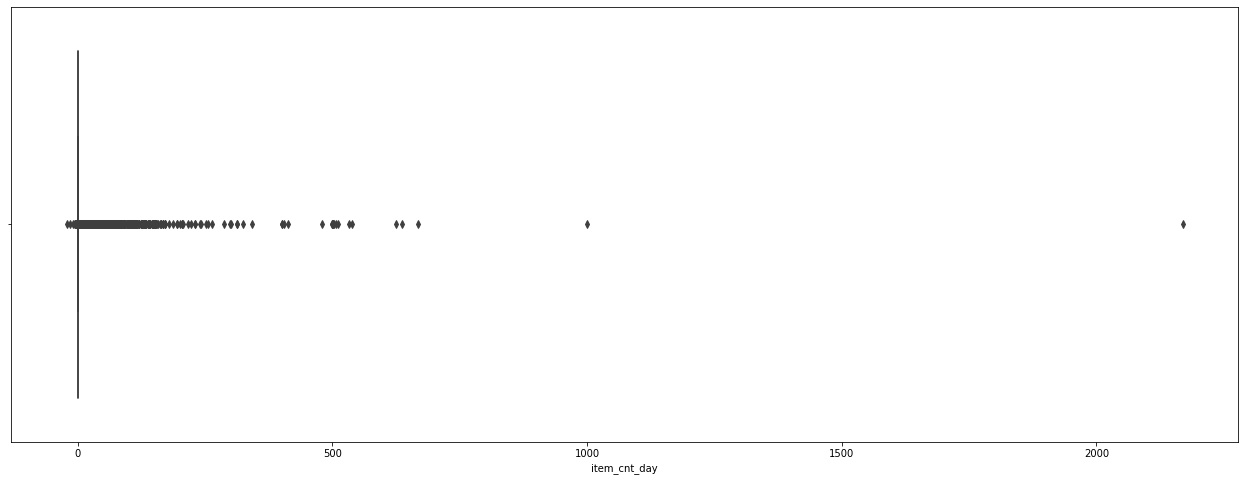

In [11]:
#We have no missing values here and we can strip off outliers
plt.subplots(figsize=(22, 8))
sns.boxplot(salesData['item_cnt_day'])
plt.show()

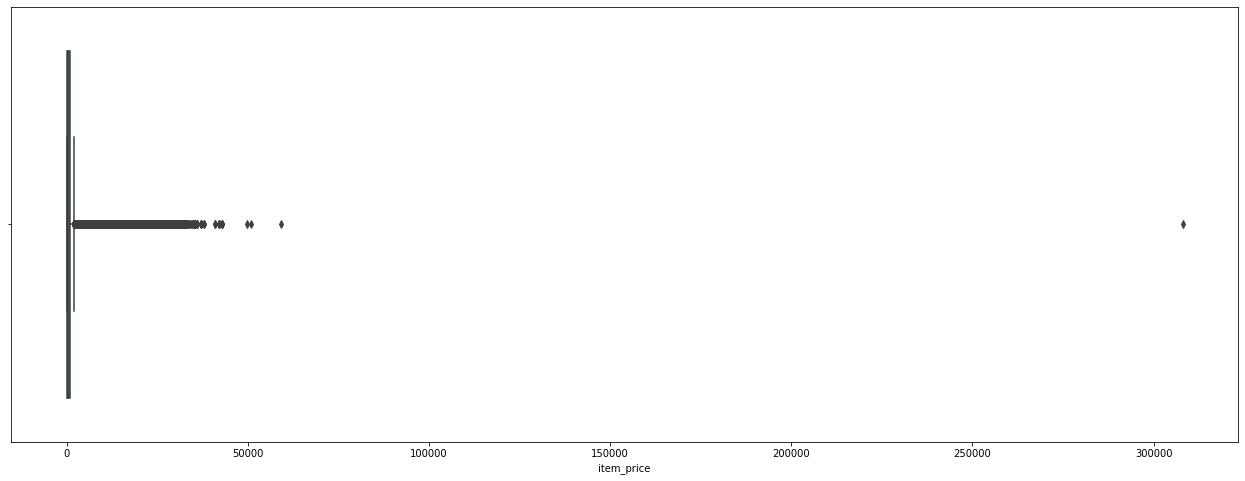

In [12]:
#We have extreme outlier in both cases of avg_price and target
plt.subplots(figsize=(22, 8))
sns.boxplot(salesData['item_price'])
plt.show()

In [13]:
#There is some pattern in shop names and category names
#More than 90% Catrgories have - in their names and they represents label
tmpCat= itemCategories.copy()
tmpCat['isHyphenInName']= tmpCat['item_category_name'].apply(lambda x: 1 if '-' in x else 0)
tmpCat['isHyphenInName'].sum()/tmpCat.shape[0]

0.9166666666666666

In [14]:
#Looking at shop names show a pattern of same first words and they represents 
#city name according to discussion forums on Kaggle
tmpShops= shops.copy()
tmpShops['firstWordInName']= tmpShops['shop_name'].apply(lambda x: x.split(' ')[0])
tmpShops['firstWordInName'].nunique()/tmpShops.shape[0]

0.5333333333333333

In [15]:
#let is check the shop values
np.unique(shops.shop_name.values)

array(['!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Адыгея ТЦ "Мега"', 'Балашиха ТРК "Октябрь-Киномир"',
       'Волжский ТЦ "Волга Молл"', 'Вологда ТРЦ "Мармелад"',
       'Воронеж (Плехановская, 13)', 'Воронеж ТРЦ "Максимир"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля',
       'Жуковский ул. Чкалова 39м?', 'Жуковский ул. Чкалова 39м²',
       'Интернет-магазин ЧС', 'Казань ТЦ "Бехетле"',
       'Казань ТЦ "ПаркХаус" II', 'Калуга ТРЦ "XXI век"',
       'Коломна ТЦ "Рио"', 'Красноярск ТЦ "Взлетка Плаза"',
       'Красноярск ТЦ "Июнь"', 'Курск ТЦ "Пушкинский"',
       'Москва "Распродажа"', 'Москва МТРЦ "Афи Молл"',
       'Москва Магазин С21', 'Москва ТК "Буденовский" (пав.А2)',
       'Москва ТК "Буденовский" (пав.К7)', 'Москва ТРК "Атриум"',
       'Москва ТЦ "Ареал" (Беляево)', 'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "Новый век" (Новокосино)', 'Москва ТЦ "Перловский"',
       'Москва Т

In [16]:
#Looks like we have duplicates 
#!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран' 
#'Якутск Орджоникидзе, 56', 'Якутск ТЦ "Центральный"'
#'Жуковский ул. Чкалова 39м?' - this value is incorrect
#Lets fix them
# Якутск Орджоникидзе, 56
salesData.loc[salesData.shop_id == 0, 'shop_id'] = 57
testDF.loc[testDF.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
salesData.loc[salesData.shop_id == 1, 'shop_id'] = 58
testDF.loc[testDF.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
salesData.loc[salesData.shop_id == 10, 'shop_id'] = 11
testDF.loc[testDF.shop_id == 10, 'shop_id'] = 11

#shops.shop_name = shops.shop_name.apply(lambda name: name.replace("!", ""))
#shops.shop_name = shops.shop_name.apply(lambda name: name.replace("39м?", "39м²"))
np.unique(shops.shop_name.values)

array(['!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Адыгея ТЦ "Мега"', 'Балашиха ТРК "Октябрь-Киномир"',
       'Волжский ТЦ "Волга Молл"', 'Вологда ТРЦ "Мармелад"',
       'Воронеж (Плехановская, 13)', 'Воронеж ТРЦ "Максимир"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля',
       'Жуковский ул. Чкалова 39м?', 'Жуковский ул. Чкалова 39м²',
       'Интернет-магазин ЧС', 'Казань ТЦ "Бехетле"',
       'Казань ТЦ "ПаркХаус" II', 'Калуга ТРЦ "XXI век"',
       'Коломна ТЦ "Рио"', 'Красноярск ТЦ "Взлетка Плаза"',
       'Красноярск ТЦ "Июнь"', 'Курск ТЦ "Пушкинский"',
       'Москва "Распродажа"', 'Москва МТРЦ "Афи Молл"',
       'Москва Магазин С21', 'Москва ТК "Буденовский" (пав.А2)',
       'Москва ТК "Буденовский" (пав.К7)', 'Москва ТРК "Атриум"',
       'Москва ТЦ "Ареал" (Беляево)', 'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "Новый век" (Новокосино)', 'Москва ТЦ "Перловский"',
       'Москва Т

In [17]:
#Filtering data after EDA
salesData= filteredTrainDataWithItemPair
salesData=salesData[ (salesData['item_price']<50000) & (salesData['item_cnt_day']<500)]

In [18]:
targetDF= salesData.groupby(['item_id','shop_id','date_block_num'],as_index=False).agg({'item_cnt_day':['sum'],'item_price':'mean'})
targetDF.columns= ['item_id','shop_id','date_block_num','target','avg_price']

In [19]:
#cartesian of item,shop,date pair
#Need to create every item,shop pair, just similar to courseera Week 4 assignment

start_time = time.time()
cartesianList=[]
for i in range(34):
    tmpDF= targetDF[targetDF['date_block_num']==i]
    shopIDList= tmpDF['shop_id'].unique()
    itemIDList= tmpDF['item_id'].unique()
    cartesianRes = list(product(*[shopIDList, itemIDList, [i]]))
    cartesianList.append(cartesianRes)
cartesianList= np.vstack(cartesianList)
cartesianDF= pd.DataFrame(cartesianList,columns=['shop_id','item_id','date_block_num'])
del cartesianList

print("--- %s seconds ---" % (time.time() - start_time))

--- 7.679673433303833 seconds ---


In [20]:
#Merging test data with date_block_num = 34
testDF['date_block_num'] = 34
testDF['date_block_num'] = testDF['date_block_num'].astype(np.int8)
testDF['shop_id'] = testDF['shop_id'].astype(np.int8)
testDF['item_id'] = testDF['item_id'].astype(np.int16)

cartesianDF = pd.concat([cartesianDF, testDF], ignore_index=True, sort=False, keys=['shop_id','item_id','date_block_num'])

In [21]:
start_time = time.time()
resDF= cartesianDF.merge(targetDF,how='left',on=['shop_id','item_id','date_block_num'])
print("--- %s seconds ---" % (time.time() - start_time))

--- 5.282384395599365 seconds ---


In [22]:
start_time = time.time()

resDF['target'].fillna(0,inplace=True)
# just a tip from discussion forum -- https://mlwhiz.com/blog/2017/12/26/win_a_data_science_competition/
resDF['target']=resDF['target'].clip(0,40)

# First get avg item price by month to fill empty places in price
itemPrice= salesData.groupby(['item_id','date_block_num'],as_index=False).agg({'item_price':'mean'})
itemPrice.columns=['item_id','date_block_num','avg_price_item']
resDF['avg_price'][ resDF['avg_price'].isna() ]= resDF[ resDF['avg_price'].isna() ].merge(itemPrice,how='left',on=['item_id','date_block_num'])['avg_price_item'].values 

print("--- %s seconds ---" % (time.time() - start_time))
resDF.describe().T

C:\Users\Maks Konyaev\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


--- 9.297147989273071 seconds ---


,count,mean,std,min,25%,50%,75%,max
shop_id,10600939.0,31.228952,17.356838,0.00,16.000000,30.0,47.00,59.0
item_id,10600939.0,11255.688619,6213.204837,1.00,5871.000000,11342.0,16540.00,22169.0
date_block_num,10600939.0,15.512365,9.798283,0.00,7.000000,15.0,23.00,34.0
ID,214200.0,107099.500000,61834.358168,0.00,53549.750000,107099.5,160649.25,214199.0
target,10600939.0,0.287430,1.439041,0.00,0.000000,0.0,0.00,40.0
avg_price,10386739.0,679.921196,1384.068392,0.09,192.153846,299.0,699.00,49782.0


In [23]:
# Now fill the remaining price lags with avg item price
itemPrice= salesData.groupby(['item_id'],as_index=False).agg({'item_price':'mean'})
itemPrice.columns=['item_id','avg_price_item']
resDF['avg_price'][ resDF['avg_price'].isna() ] = resDF[ resDF['avg_price'].isna() ].merge(itemPrice,how='left',on=['item_id'])['avg_price_item'].values 


C:\Users\Maks Konyaev\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [24]:
#Merging Data
shops['shop_label']= shops['shop_name'].apply( lambda x: x.split(' ')[0])
le = preprocessing.LabelEncoder()
shops['shop_label']= le.fit_transform(shops['shop_label'])

In [25]:
itemCategories['cat_label']= itemCategories['item_category_name'].apply(lambda x: x.split('-')[0].strip())
itemCategories['cat_subLabel']= itemCategories['item_category_name'].apply(lambda x: x.split('-')[1].strip() if '-' in x else x.split('-')[0].strip())

le = preprocessing.LabelEncoder()
itemCategories['cat_label']= le.fit_transform(itemCategories['cat_label'])
itemCategories['cat_subLabel']= le.fit_transform(itemCategories['cat_subLabel'])

In [26]:
#TFIDF features

#items_subset = items[['item_id', 'item_name']]
#feature_count = 25
#tfidf = TfidfVectorizer(max_features=feature_count)
#items_df_item_name_text_features = pd.DataFrame(tfidf.fit_transform(items_subset['item_name']).toarray())

#cols = items_df_item_name_text_features.columns
#for i in range(feature_count):
#    feature_name = 'item_name_tfidf_' + str(i)
#    items_subset[feature_name] = items_df_item_name_text_features[cols[i]]

#items_subset.drop('item_name', axis = 1, inplace = True)
#resDF = resDF.merge(items_subset, on = 'item_id', how = 'left')

In [27]:
resDF= resDF.merge(items[['item_id','item_category_id']],on=['item_id'],how='left')
resDF= resDF.merge(itemCategories[['cat_label','cat_subLabel','item_category_id']],how='left',on=['item_category_id'])
resDF= resDF.merge(shops[['shop_label','shop_id']],how='left',on=['shop_id'])

In [28]:
#Mean Encoding
meanEncodingCols =[
    ( ['shop_id'],[1,2,3,6,12]),
    ( ['item_id'],[1,2,3,6,12]),
    ( ['item_category_id'],[1,2,3,6,12]),
    (['item_id','shop_id'],[1,2,3,6,12]),
    (['item_category_id','shop_id'],[1,2,3,6,12]),
    (['cat_label'],[1]),
    (['cat_label','item_id'],[1,2,3]),
    (['cat_subLabel'],[1]),
    (['shop_label'],[1])
]

In [29]:
#Just a function, I used to avoid writing redundant code of similar column names
def generateGroupByFeatures(ipDF,groupCols,aggDict):
    groupByAlias = {'item_id':'item','shop_id':'shop','item_category_id':'item_cat','date_block_num':'date',
                    'month':'month','target':'target','cat_label':'cat_label','cat_subLabel':'cat_subLabel',
                   'shop_label':'shop_label'}
    aggColAlias= {'item_cnt_day':'cnt','item_price':'price','target':'target','avg_price':'price'}
    
    grpByName= '_'.join( [groupByAlias[x] for x in groupCols] )+'_'
    colNameList=[]
    
    for aggCol,aggFnArr in aggDict.items():
        for f in aggFnArr:
            fName = f.__name__ if hasattr(f, '__call__') else f
            colNameList.append( grpByName+aggColAlias[aggCol]+"_"+fName )
    returnDF= ipDF.groupby(groupCols,as_index=False).agg(aggDict)
    returnDF.columns= groupCols+colNameList
    return returnDF

In [30]:
for c in resDF.columns:
    if 'int' in str(resDF[c].dtype):
        resDF[c]= resDF[c].astype('Int32')
        if resDF[c].max()<32000:
            resDF[c]= resDF[c].astype('Int16')
        if resDF[c].max()<120:
            resDF[c]= resDF[c].astype('Int8')
    if 'float' in str(resDF[c].dtype):
        resDF[c]= resDF[c].astype('Float32')
        if resDF[c].max()<65000:
            resDF[c]= resDF[c].astype('Float16')

In [31]:
#Price related Features
grpByItem= generateGroupByFeatures(salesData,['item_id'],{'item_price':['min','max',np.var]})
grpByItem['historic_price_shift']= (grpByItem['item_price_max']-grpByItem['item_price_min'])/grpByItem['item_price_max']
grpByItem.drop(['item_price_max','item_price_min'],axis=1,inplace=True)
resDF= resDF.merge(grpByItem,how='left',on=['item_id'])

In [ ]:
#Lag features
start_time = time.time()

for m in meanEncodingCols:
    grpCols= m[0]
    lagArr= m[1]
    
    tmpDF= resDF.copy()
    grpCols= grpCols+['date_block_num']
    groupDF= generateGroupByFeatures(tmpDF,grpCols,{'target':['mean']})
    tmpDF= tmpDF.merge(groupDF,how='left',on= grpCols)
    
    # mean encoded column
    meanEncodedColName= [c for c in groupDF.columns if 'target_mean' in c]
    assert len(meanEncodedColName)==1
    meanEncodedColName= meanEncodedColName[0]
    
    for lag in lagArr:
        shiftedDF= tmpDF[['item_id','shop_id','date_block_num',meanEncodedColName]].copy()
        shiftedDF['date_block_num']= shiftedDF['date_block_num']+lag
        
        lagColName= meanEncodedColName+"_lag_"+str(lag)
        shiftedDF.rename({meanEncodedColName:lagColName},axis=1,inplace=True)
        
        resDF= resDF.merge(shiftedDF,how='left',on=['item_id','shop_id','date_block_num'])
        del shiftedDF
    del tmpDF

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#Price lag of item and item_categories
start_time = time.time()

for lag in [1,2,3]:
    tmpDF= resDF[['item_id','date_block_num','avg_price']].copy()
    tmpDF['date_block_num']+= lag
    tmpGrpByItem= tmpDF.groupby(['item_id','date_block_num'],as_index=False).agg({'avg_price':['mean']})
    tmpGrpByItem.columns= ['item_id','date_block_num','item_price_lag'+str(lag)]
    
    resDF= resDF.merge(tmpGrpByItem,how='left',on=['item_id','date_block_num'])
    del tmpGrpByItem
    del tmpDF

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
start_time = time.time()

for lag in [1,2,3]:
    tmpDF= resDF[['item_category_id','date_block_num','avg_price']].copy()
    tmpDF['date_block_num']+= lag
    tmpGrpByItem= tmpDF.groupby(['item_category_id','date_block_num'],as_index=False).agg({'avg_price':['mean']})
    tmpGrpByItem.columns= ['item_category_id','date_block_num','item_cat_price_lag'+str(lag)]
    
    resDF= resDF.merge(tmpGrpByItem,how='left',on=['item_category_id','date_block_num'])
    del tmpGrpByItem
    del tmpDF
    
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#Fill empty lag sales values with 0

for col in resDF.columns:
    if 'price' not in col and ( resDF[col].isnull().any() ):
        resDF[col].fillna(0, inplace=True)

In [ ]:
#Fill empty lag price values with median

for col in resDF.columns:
    if 'price' in col:
        resDF[col]= resDF[col].fillna(resDF[col].median())
gc.collect()

In [ ]:
#Save the model
resDF.to_pickle('data.pkl')

In [ ]:
resDF = pd.read_pickle("data.pkl")

In [ ]:
#Create month and days feature
#days = {0 : 31, 1: 28, 2: 31, 3: 30, 4: 31,5: 30,6: 31,7: 31,8: 30,9: 31,10: 30, 11: 31}
resDF['month']= resDF['date_block_num']%12
#resDF['days']= resDF['month'].map(days)
resDF=resDF[ resDF['date_block_num']>12 ]

In [ ]:
#Here we are normalizing price values, and they are showing better performance according to my experiments

for c in ['item_price_lag1', 'item_price_lag2','item_price_lag3']:
    resDF[c+'_diff']= resDF[c]/resDF['avg_price']
    resDF.drop([c],axis=1,inplace=True)


In [ ]:
resDF.describe().T

In [ ]:
for c in resDF.columns:
    if 'int' in str(resDF[c].dtype).lower():
        resDF[c]= resDF[c].astype('int32')
    if 'float' in str(resDF[c].dtype).lower():
        resDF[c]= resDF[c].astype('float32')

In [ ]:
resDF.dtypes

In [ ]:
start_time = time.time()

X= resDF[resDF['date_block_num']<33]
Y= X['target']
X.drop(['target'],axis=1,inplace=True)

X_val= resDF[(resDF['date_block_num']==33)&(resDF['target']==0)]
Y_val= X_val['target']
X_val.drop(['target'],axis=1,inplace=True)

X_val_1= resDF[(resDF['date_block_num']==33)&(resDF['target']!=0)]
Y_val_1= X_val_1['target']
X_val_1.drop(['target'],axis=1,inplace=True)

In [ ]:
model = pickle.load(open("tree.dat", 'rb'))

In [ ]:
model = xgb.XGBRegressor(max_depth=6 ,
    n_estimators=300,
    #random_state = 0,
    #min_samples_split = 20,
    min_child_weight=20, 
    colsample_bytree=0.6,
    seed=42,
    n_jobs=-1)

model.fit(X,Y,
          eval_metric="rmse", 
          eval_set=[(X,Y),(X_val, Y_val),(X_val_1, Y_val_1)],
          verbose=20,
          early_stopping_rounds=10
         )

print("--- %s seconds ---" % (time.time() - start_time))

pickle.dump(model, open("tree.dat", "wb"))

In [ ]:
#Linear Regression
start_time = time.time()


X= resDF[resDF['date_block_num']<33]
Y= X['target']
X.drop(['target'],axis=1,inplace=True)

X_val= resDF[(resDF['date_block_num']==33)]
Y_val= X_val['target']
X_val.drop(['target'],axis=1,inplace=True)

lr = LinearRegression(n_jobs=-1)

lr.fit(X.values, Y.values)

print("--- %s seconds ---" % (time.time() - start_time))

pickle.dump(lr, open("lr.pickle.dat", "wb"))

In [ ]:
#Ensembling
X_train= resDF[resDF['date_block_num']<33].drop(['target'],axis=1)
X_test= resDF[resDF['date_block_num']==34].drop(['target'],axis=1)
X_val= resDF[resDF['date_block_num']==33].drop(['target'],axis=1)

Y_train= resDF[resDF['date_block_num']<33]['target']
Y_val= resDF[resDF['date_block_num']==33]['target']

treeModel = model;lrModel= lr;

In [ ]:
meta_xg_train= treeModel.predict(X_train)
meta_lr_train= lrModel.predict(X_train)

meta_xg_val= treeModel.predict(X_val)
meta_lr_val= lrModel.predict(X_val)

meta_xg_test= treeModel.predict(X_test)
meta_lr_test= lrModel.predict(X_test)

metaTrain= np.c_[meta_xg_train,meta_lr_train]
print(metaTrain.shape,Y_train.shape)

metaVal= np.c_[meta_xg_val,meta_lr_val]
print(metaVal.shape,Y_val.shape)

metaTest= np.c_[meta_xg_test,meta_lr_test]
print(metaTest.shape)

In [ ]:
lr= LinearRegression(n_jobs=-1)
lr.fit(metaTrain,Y_train.values)

metaVal= np.c_[meta_xg_val,meta_lr_val]
Y_train_pred= lr.predict(metaTrain)
Y_val_pred= lr.predict(metaVal)


print(np.sqrt(mean_squared_error(Y_val_pred,Y_val.values)))
print(np.sqrt(mean_squared_error(Y_train_pred,Y_train.values)))

In [ ]:
drop_cols= [ 'target']
testDF = resDF[ resDF['date_block_num']==34]
testDF['target']= lr.predict(metaTest)

submission = pd.DataFrame({
    "ID": testDF['ID'], 
    "item_cnt_month": testDF['target'].clip(0,20)
})
submission['ID']= submission['ID'].astype(np.int32)
submission.to_csv('submission.csv', index=False)